In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import time
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [3]:
df=pd.read_excel(r"../dataset/data.xlsx",sheet_name="Sheet1")
df

,Number of Storeys(NS),Height of Structure(HS),Number of Spans(HSP),Length of Spans (LS),Opening percentage (OP),Masonry wall Stiffeness Et (MS),Period (P)
0,1,3,2,3.0,0,2.25,0.092970
1,1,3,2,3.0,100,2.25,0.159750
2,1,3,2,4.5,0,2.25,0.094770
3,1,3,2,4.5,100,2.25,0.156589
4,1,3,2,6.0,0,2.25,0.106350
...,...,...,...,...,...,...,...
4021,22,66,6,6.0,50,25.00,1.628000
4022,22,66,6,6.0,75,25.00,2.714000
4023,22,66,6,6.0,100,25.00,2.879000
4024,22,66,6,7.5,0,25.00,0.602680


In [4]:
df.shape

(4026, 7)

In [5]:
df.head()

,Number of Storeys(NS),Height of Structure(HS),Number of Spans(HSP),Length of Spans (LS),Opening percentage (OP),Masonry wall Stiffeness Et (MS),Period (P)
0,1,3,2,3.0,0,2.25,0.092970
1,1,3,2,3.0,100,2.25,0.159750
2,1,3,2,4.5,0,2.25,0.094770
3,1,3,2,4.5,100,2.25,0.156589
4,1,3,2,6.0,0,2.25,0.106350


In [6]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df)

normalized_df = pd.DataFrame(normalized_data, columns=df.columns)

print(normalized_df)

      Number of Storeys(NS)  Height of Structure(HS)  Number of Spans(HSP)  \
0                       0.0                      0.0                   0.0   
1                       0.0                      0.0                   0.0   
2                       0.0                      0.0                   0.0   
3                       0.0                      0.0                   0.0   
4                       0.0                      0.0                   0.0   
...                     ...                      ...                   ...   
4021                    1.0                      1.0                   1.0   
4022                    1.0                      1.0                   1.0   
4023                    1.0                      1.0                   1.0   
4024                    1.0                      1.0                   1.0   
4025                    1.0                      1.0                   1.0   

      Length of Spans (LS)  Opening percentage (OP)  \
0       

In [7]:
normalized_df.keys()

Index(['Number of Storeys(NS)', 'Height of Structure(HS)',
       'Number of Spans(HSP)', 'Length of Spans (LS)',
       'Opening percentage (OP)', 'Masonry wall Stiffeness Et (MS)',
       'Period (P)'],
      dtype='object')

In [8]:
X=normalized_df.drop("Period (P)" ,axis=1)

In [9]:
y=normalized_df["Period (P)"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=99)

In [11]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold,cross_validate
from bayes_opt import BayesianOptimization
from hyperopt import hp,fmin,tpe,Trials,partial
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
import optuna.integration.lightgbm as oplgb

In [20]:
def bayesopt_objective(max_depth):
    model= DecisionTreeRegressor(max_depth=int(max_depth) )
    
    cv=KFold(n_splits=10,shuffle=True,random_state=99)
    validate_loss=cross_validate(model,X_train,y_train
                                   ,cv=cv
                                   ,scoring='neg_root_mean_squared_error'
                                   ,n_jobs=-1
                                   ,error_score='raise')
    
    return np.mean(abs(validate_loss['test_score']))

In [21]:
def param_bayes_opt(init_points,n_iter):
    opt=BayesianOptimization(bayesopt_objective
                             ,param_grid_simple
                             ,random_state=99)
    
    opt.maximize(init_points=init_points 
                 ,n_iter=n_iter 
                )
    
        params_best=opt.max['params'] 
        score_best=opt.max['target'] 
    
    print("\n","best params: ", params_best,
          "\n","best cvscore: ", score_best)
    
    return params_best,score_best

In [22]:
# 自定义验证函数，返回bayes_opt最优参数的RMSE

def bayes_opt_validation(params_best):
    model= DecisionTreeRegressor(
            max_depth=int(params_best['max_depth'])
           )
    cv=KFold(n_splits=10,shuffle=True,random_state=99)
    validate_loss=cross_validate(model,X_train,y_train
                                   ,cv=cv
                                   ,scoring='neg_root_mean_squared_error'
                                   ,n_jobs=-1
                                  )
    
    return np.mean(abs(validate_loss['test_score']))

In [31]:
# Start time
start_time = time.time()

param_grid_simple={'max_depth':(1,10) }

params_best,score_best=param_bayes_opt(10,300)

params_best 
score_best 
validation_score=bayes_opt_validation(params_best) 
validation_score 
# End time
end_time = time.time()
# Calculate total time
total_time = end_time - start_time
print("Total time taken: ", total_time)

|   iter    |  target   | max_depth |
-------------------------------------
| 1         | 0.02641   | 7.051     |
| 2         | 0.04882   | 5.393     |
| 3         | 0.02008   | 8.429     |
| 4         | 0.165     | 1.283     |
| 5         | 0.02007   | 8.272     |
| 6         | 0.03595   | 6.091     |
| 7         | 0.09023   | 3.679     |
| 8         | 0.165     | 1.42      |
| 9         | 0.01644   | 9.916     |
| 10        | 0.165     | 1.061     |
| 11        | 0.165     | 1.697     |
| 12        | 0.165     | 1.0       |
| 13        | 0.165     | 1.572     |
| 14        | 0.165     | 1.881     |
| 15        | 0.165     | 1.785     |
| 16        | 0.1158    | 2.025     |
| 17        | 0.165     | 1.881     |
| 18        | 0.06522   | 4.47      |
| 19        | 0.09023   | 3.025     |
| 20        | 0.01643   | 9.169     |
| 21        | 0.0264    | 7.641     |
| 22        | 0.06522   | 4.918     |
| 23        | 0.06522   | 4.044     |
| 24        | 0.09023   | 3.344     |
| 25        

| 132       | 0.165     | 1.706     |
| 133       | 0.165     | 1.751     |
| 134       | 0.165     | 1.607     |
| 135       | 0.165     | 1.356     |
| 136       | 0.165     | 1.557     |
| 137       | 0.165     | 1.053     |
| 138       | 0.165     | 1.532     |
| 139       | 0.165     | 1.286     |
| 140       | 0.165     | 1.197     |
| 141       | 0.165     | 1.096     |
| 142       | 0.165     | 1.334     |
| 143       | 0.165     | 1.074     |
| 144       | 0.165     | 1.77      |
| 145       | 0.165     | 1.172     |
| 146       | 0.165     | 1.816     |
| 147       | 0.165     | 1.873     |
| 148       | 0.165     | 1.012     |
| 149       | 0.165     | 1.397     |
| 150       | 0.165     | 1.583     |
| 151       | 0.165     | 1.682     |
| 152       | 0.165     | 1.794     |
| 153       | 0.165     | 1.838     |
| 154       | 0.165     | 1.733     |
| 155       | 0.165     | 1.417     |
| 156       | 0.165     | 1.484     |
| 157       | 0.165     | 1.376     |
| 158       

| 265       | 0.165     | 1.34      |
| 266       | 0.165     | 1.551     |
| 267       | 0.165     | 1.8       |
| 268       | 0.165     | 1.383     |
| 269       | 0.165     | 1.218     |
| 270       | 0.165     | 1.365     |
| 271       | 0.165     | 1.167     |
| 272       | 0.165     | 1.678     |
| 273       | 0.165     | 1.413     |
| 274       | 0.165     | 1.569     |
| 275       | 0.165     | 1.873     |
| 276       | 0.165     | 1.714     |
| 277       | 0.165     | 1.759     |
| 278       | 0.165     | 1.124     |
| 279       | 0.165     | 1.08      |
| 280       | 0.165     | 1.295     |
| 281       | 0.165     | 1.321     |
| 282       | 0.165     | 1.638     |
| 283       | 0.165     | 1.847     |
| 284       | 0.165     | 1.185     |
| 285       | 0.165     | 1.696     |
| 286       | 0.165     | 1.04      |
| 287       | 0.165     | 1.154     |
| 288       | 0.165     | 1.098     |
| 289       | 0.165     | 1.458     |
| 290       | 0.165     | 1.515     |
| 291       

In [11]:
from sklearn.tree import DecisionTreeRegressor
params_best['max_depth'] = int(params_best['max_depth'])
dtr_reg=DecisionTreeRegressor(**params_best )
dtr_reg.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=1)

In [12]:
y_pred= dtr_reg.predict(X_test)
y_pred1=dtr_reg.predict(X_val)
y_pred2=dtr_reg.predict(X_train)

In [13]:
print("mean_absolute_error:", mean_absolute_error(y_val, y_pred1))
print("mean_squared_error:", mean_squared_error(y_val, y_pred1))
print("rmse:", sqrt(mean_squared_error(y_val, y_pred1)))
print("r2 score:", r2_score(y_val, y_pred1))

mean_absolute_error: 0.1251863957325461
mean_squared_error: 0.026161411207525593
rmse: 0.16174489546049234
r2 score: 0.47529009948082945


In [14]:
print("mean_absolute_error:", mean_absolute_error(y_train, y_pred2))
print("mean_squared_error:", mean_squared_error(y_train, y_pred2))
print("rmse:", sqrt(mean_squared_error(y_train, y_pred2)))
print("r2 score:", r2_score(y_train, y_pred2))

mean_absolute_error: 0.12914613161265726
mean_squared_error: 0.027045758431405043
rmse: 0.16445594678030054
r2 score: 0.44708994850370254


In [15]:
print("mean_absolute_error:", mean_absolute_error(y_test, y_pred))
print("mean_squared_error:", mean_squared_error(y_test, y_pred))
print("rmse:", sqrt(mean_squared_error(y_test, y_pred)))
print("r2 score:", r2_score(y_test, y_pred))

mean_absolute_error: 0.13270617681605984
mean_squared_error: 0.02857749901364489
rmse: 0.1690488066022499
r2 score: 0.4421798001431696


In [30]:
from yellowbrick.regressor import PredictionError

D:\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


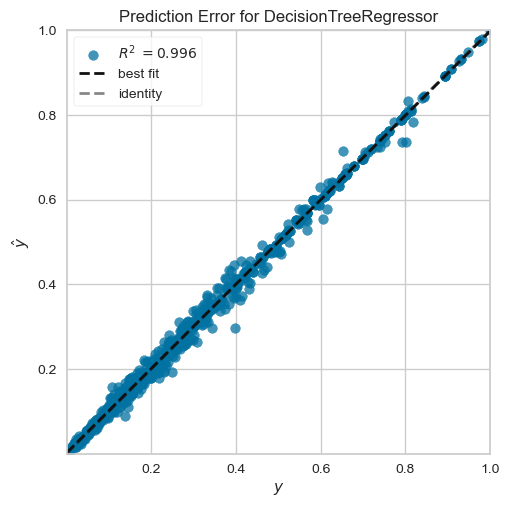

<Axes: title={'center': 'Prediction Error for DecisionTreeRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [28]:
visualizer = PredictionError(dtr_reg)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()